<font color=red><h1> 1. Loading data and packages</h1></font>

<font color=green><h2> 1.1 Loading packages</h2></font>

In [72]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
from scipy.optimize import minimize
import riskfolio as rp
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')

<font color=green><h2> 1.2 Loading Data</h2></font>

In [73]:
Start_date=datetime.strptime('2010-01-01', '%Y-%m-%d').date()
End_date=datetime.strptime('2013-01-01', '%Y-%m-%d').date()
Tickers=['AAPL','JPM','WMT','AMZN','JNJ']
Stocks=yf.download(Tickers,start=Start_date,end=End_date)

[*********************100%%**********************]  5 of 5 completed


In [74]:
Stocks_AdjClose=Stocks.loc[:,'Adj Close']
Stocks_AdjClose.head()

Ticker,AAPL,AMZN,JNJ,JPM,WMT
Date,,,,,
2010-01-04,6.454505,6.6950,41.989914,29.335232,13.113414
2010-01-05,6.465664,6.7345,41.503014,29.903456,12.982840
2010-01-06,6.362821,6.6125,41.840599,30.067760,12.953822
2010-01-07,6.351056,6.5000,41.541969,30.663364,12.961073
2010-01-08,6.393280,6.6760,41.684792,30.588060,12.895788


In [75]:
Returns=np.log(Stocks_AdjClose/Stocks_AdjClose.shift(1))
Returns.dropna(axis=0,inplace=True)
Returns.head()

Ticker,AAPL,AMZN,JNJ,JPM,WMT
Date,,,,,
2010-01-05,0.001727,0.005883,-0.011663,0.019185,-0.010007
2010-01-06,-0.016034,-0.018282,0.008101,0.005479,-0.002238
2010-01-07,-0.001851,-0.017160,-0.007163,0.019615,0.000560
2010-01-08,0.006626,0.026717,0.003432,-0.002459,-0.005050
2010-01-11,-0.008861,-0.024335,0.000156,-0.003363,0.016366


In [76]:
#Annualizing input parameters
mu=Returns.mean()*252
sigma=Returns.cov()*252

print("Expected Returns")
print(tabulate(pd.DataFrame(mu,columns=['Expected Returns']),headers="keys", tablefmt='fancy_grid'))


print('Covariance Matrix')
print(tabulate(pd.DataFrame(sigma),headers="keys", tablefmt='fancy_grid'))

Expected Returns
╒══════════╤════════════════════╕
│ Ticker   │   Expected Returns │
╞══════════╪════════════════════╡
│ AAPL     │          0.307815  │
├──────────┼────────────────────┤
│ AMZN     │          0.210114  │
├──────────┼────────────────────┤
│ JNJ      │          0.0626551 │
├──────────┼────────────────────┤
│ JPM      │          0.0269003 │
├──────────┼────────────────────┤
│ WMT      │          0.101662  │
╘══════════╧════════════════════╛
Covariance Matrix
╒══════════╤═══════════╤═══════════╤════════════╤═══════════╤════════════╕
│ Ticker   │      AAPL │      AMZN │        JNJ │       JPM │        WMT │
╞══════════╪═══════════╪═══════════╪════════════╪═══════════╪════════════╡
│ AAPL     │ 0.0751628 │ 0.0412662 │ 0.0148908  │ 0.0367338 │ 0.011844   │
├──────────┼───────────┼───────────┼────────────┼───────────┼────────────┤
│ AMZN     │ 0.0412662 │ 0.117716  │ 0.0174558  │ 0.0420045 │ 0.0125352  │
├──────────┼───────────┼───────────┼────────────┼───────────┼────────────

<font color=green><h2> 1.3 Returns Dynamics Over time</h2></font>

In [77]:
Colors=['blue','red','green','olive','purple']
Trace=list(np.ones(len(Tickers)))
for i in range(len(Tickers)):
  Trace[i] = go.Scatter(x=Stocks_AdjClose.index,y=Stocks_AdjClose.iloc[:,i],name=Stocks_AdjClose.columns[i],line=dict(color=Colors[i], width=2),marker=dict(size=2))

layout = go.Layout(xaxis = dict(title = 'Date'),yaxis = dict(title = 'Adj Close'),template = 'plotly_white' )

fig = go.Figure(data=Trace, layout=layout,)

fig.show()

<font color=red><h1> 2. Problem Formulation</h1></font>

![Risk Parity 2](./Parity1.JPG)

![Risk Parity 2](./Parity2.JPG)

In [87]:
def parity_function(Weights,cov_matrix,b):
    Variance=np.dot(Weights, np.dot(sigma, Weights.T))
    RRC=(Weights*np.dot(sigma, Weights.T))/Variance
    RBE=(RRC-b)**2
    return(np.sum(RBE))
    

In [88]:
# All the weights should sum up to 1

constraints1={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Initial weights are the points of start of the optimization algorithm
initial_weights=np.ones(len(Returns.columns))/len(Returns.columns)

# The short selling constraint
bounds = tuple((0, 1) for _ in initial_weights)

In [89]:
res = minimize(lambda x:parity_function(x,np.array(sigma), np.array(initial_weights)),x0=initial_weights,method='SLSQP',constraints=constraints1,bounds=bounds,tol=1e-20)
Weights=pd.DataFrame(res.x,index=Returns.columns)

<font color=green><h2> 2.1 RPP vs EWP portfolios</h2></font>

<font color=orange><h2> 2.1.1 RPP portfolio</h2></font>

Text(0.5, 1.0, 'Portfolio allocation of RPP')

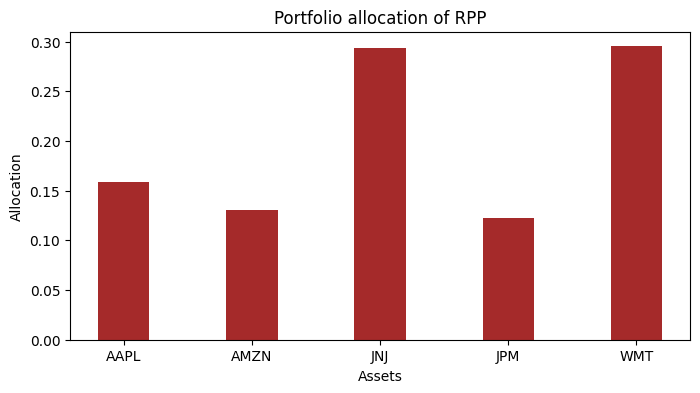

In [97]:
fig = plt.figure(figsize = (8, 4))
plt.bar(Weights.index,Weights.iloc[:,0].values,color='brown',width=0.4)
plt.xlabel('Assets')
plt.ylabel('Allocation')
plt.title('Portfolio allocation of RPP')

Text(0.5, 1.0, 'Relative Risk Contribution of RPP')

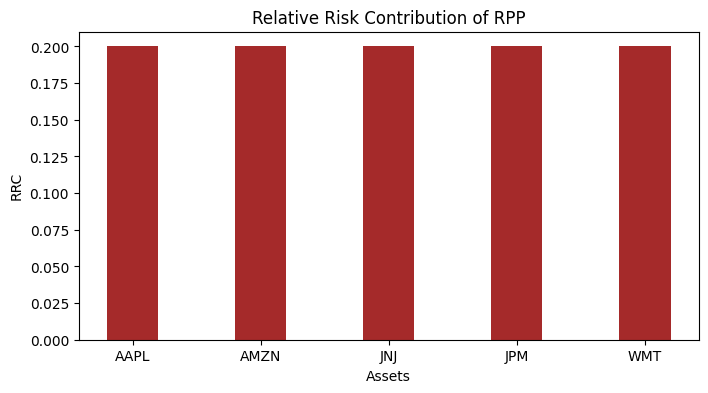

In [102]:
Variance=np.dot(res.x, np.dot(sigma, (res.x).T))
RRC=(res.x*np.dot(sigma, res.x.T))/Variance
fig = plt.figure(figsize = (8, 4))
plt.bar(Weights.index,RRC,color='brown',width=0.4)
plt.xlabel('Assets')
plt.ylabel('RRC')
plt.title('Relative Risk Contribution of RPP')

<font color=orange><h2> 2.1.2 EWP portfolio</h2></font>

Text(0.5, 1.0, 'Portfolio allocation of EWP')

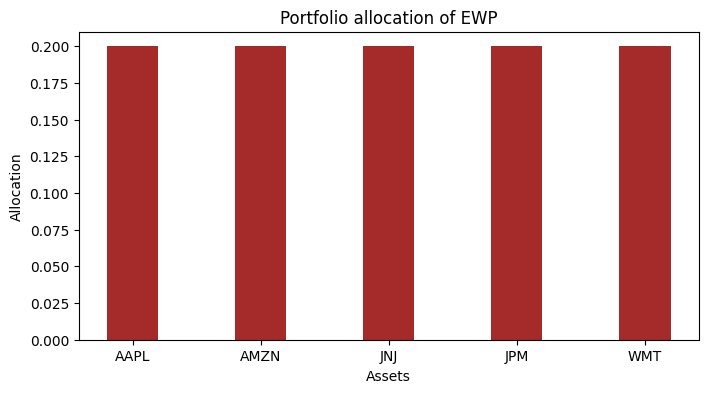

In [108]:
fig = plt.figure(figsize = (8, 4))
plt.bar(Weights.index,initial_weights,color='brown',width=0.4)
plt.xlabel('Assets')
plt.ylabel('Allocation')
plt.title('Portfolio allocation of EWP')

Text(0.5, 1.0, 'Relative Risk Contribution of EWP')

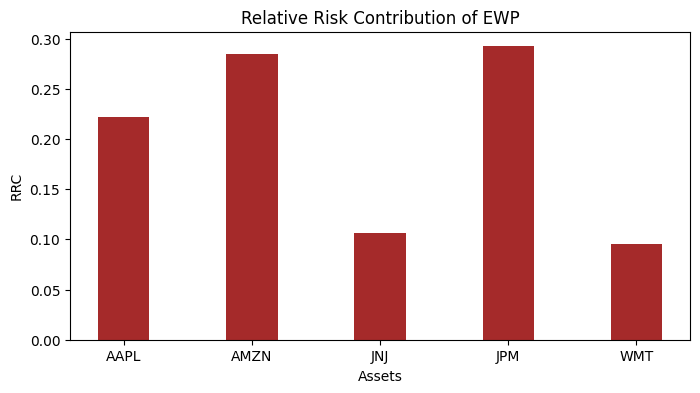

In [109]:
Variance=np.dot(initial_weights, np.dot(sigma, initial_weights.T))
RRC=(initial_weights*np.dot(sigma, initial_weights.T))/Variance
fig = plt.figure(figsize = (8, 4))
plt.bar(Weights.index,RRC,color='brown',width=0.4)
plt.xlabel('Assets')
plt.ylabel('RRC')
plt.title('Relative Risk Contribution of EWP')